In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
import operator
from sklearn.preprocessing import StandardScaler, Imputer
from scipy.spatial.distance import euclidean, cosine
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor


In [526]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [520]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [68]:
def rmse(yhat, y, round_to = None):
    ''' Return root mean squared error of a set of predictions '''
    err = np.sqrt(((yhat - y)**2).mean())
    if round_to:
        return round(err, round_to)
    else:
        return err

In [511]:
df = pd.read_csv('../data/data_for_model.csv', index_col='Season_Player')
df.drop([
    'Player', 'Season_Player.1', 'Season', 'Season_index'
], axis=1, inplace=True)

In [512]:
df['forward'] = (df['position'] != 'Defense')

In [513]:
df['signing_status'] = df.signing_status.apply(lambda x: 1 if 'UFA' else 0)

In [514]:
#These columns were causing problems
df.drop(['mean SH%', 'IPP', 'mean Faceoffs pct'], axis =1, inplace = True)

In [638]:
ycols = ['cap_hit', 'length', 'total_value', 'cap_pct', 'signing_year_cap']
xcols = ['forward', 'signing_age', 'signing_status'] + list(df.columns)[10:]
#xcols = ['forward', 'signing_age', 'mean Total Points/60', 'TOI/GP', 'Off. Zone Start %']

In [639]:
X, y = df[xcols], df[ycols]

In [517]:
X.shape

(1170, 197)

In [505]:
xcols[83], xcols[177], xcols[196]

('mean SH%', 'IPP', 'mean Faceoffs pct')

In [640]:
X.replace('-', 0, inplace=True)

X = X.apply(pd.to_numeric)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose = 1)
X = imp.fit_transform(X)

In [635]:
X.shape

(1170, 5)

In [641]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

In [626]:
X_train.shape, yp_train.shape, yl_train.shape, scap_train.shape

((994, 4), (994,), (994,), (994,))

In [577]:
def predict_global_mean(yp_train, yp_test, yl_train, yl_test):
    pcmp = yp_train.mean()
    p_rmse = rmse(pcmp, yp_test, 2)
    print('RMSE pick mean cap_pct: {}%'.format(p_rmse))
    print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))
    pcml = yl_train.mean()
    print('RMSE pick mean length: {} years'.format(rmse(pcml, yl_test, 1)))
    return pcmp, pcml

In [565]:
predict_global_mean(yp_train, yp_test, yl_train, yl_test)

RMSE pick mean cap_pct: 2.82%
    translates to 2019 Cap Hit of: 2340600.0
RMSE pick mean length: 1.7 years


(2.596197183098589, 2.2515090543259557)

In [709]:
reg_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, KNeighborsRegressor]

def run_regressor(split, m = GradientBoostingRegressor):
    '''
    Run a list of regression models for salary cap percent and contract length. 
    Predicted cap_pct is used as a feature for contract length.
    '''
    X_tr, X_te, yp_tr, yp_te, yl_tr, yl_te, scap_tr, scap_te = split 
    if m == LinearRegression:
        print(m.__name__)
        run_lin_regressor()
    else:
        print(m.__name__)
        model = m()
        model.fit(X_tr, yp_tr)
        cap_preds = model.predict(X_te)
        p_rmse = rmse(cap_preds, yp_te, 2)
        print('RMSE Cap_pct: {}%'.format(p_rmse))
        print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))
        

        Xl_tr, Xl_te = X_tr.copy(), X_te.copy()
        Xl_tr = np.hstack((Xl_tr, model.predict(Xl_tr).reshape(-1,1)))
        Xl_te = np.hstack((Xl_te, cap_preds.reshape(-1,1)))

        l_model = m()
        l_model.fit(Xl_tr, yl_tr)
        length_preds = l_model.predict(Xl_te)
        l_rmse = rmse(length_preds, yl_te, 1)
        print('RMSE Length: {} years'.format(rmse(length_preds, yl_te, 1)))
        
        return p_rmse, l_rmse
    
def run_lin_regressor():
    X_tr, X_te, yp_tr, yp_te, yl_tr, yl_te, scap_tr, scap_te = split
    model = LinearRegression()
    model.fit(X_tr, yp_tr)
    cap_preds = model.predict(X_te)
    p_rmse = rmse(cap_preds, yp_te, 2)
    print('RMSE Cap_pct: {}%'.format(p_rmse))
    print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

    Xl_tr, Xl_te = X_tr.copy(), X_te.copy()
    Xl_tr = np.hstack((Xl_tr, model.predict(Xl_tr).reshape(-1,1), (Xl_tr[:,1]**2).reshape(-1,1)))
    Xl_te = np.hstack((Xl_te, cap_preds.reshape(-1,1), (Xl_te[:,1]**2).reshape(-1,1)))

    l_model = LinearRegression()
    l_model.fit(Xl_tr, yl_tr)
    length_preds = l_model.predict(Xl_te)
    l_rmse = rmse(length_preds, yl_te, 1)
    print('RMSE Length: {} years'.format(rmse(length_preds, yl_te, 1)))
    
    return p_rmse, l_rmse

In [717]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

for r in reg_list:
    run_regressor(split, r)
    print()

RMSE pick mean cap_pct: 2.75%
    translates to 2019 Cap Hit of: $2282500.0
RMSE pick mean length: 1.8 years

LinearRegression
RMSE Cap_pct: 1.12%
    translates to 2019 Cap Hit of: $929600.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 0.99%
    translates to 2019 Cap Hit of: $821700.0
RMSE Length: 1.1 years

GradientBoostingRegressor
RMSE Cap_pct: 0.81%
    translates to 2019 Cap Hit of: $672300.0
RMSE Length: 1.0 years

AdaBoostRegressor
RMSE Cap_pct: 1.19%
    translates to 2019 Cap Hit of: $987700.0
RMSE Length: 1.2 years

KNeighborsRegressor
RMSE Cap_pct: 1.31%
    translates to 2019 Cap Hit of: $1087300.0
RMSE Length: 1.3 years



In [718]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(n_estimators = 100)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))


Xl_train, Xl_test = X_train.copy(), X_test.copy()
Xl_train = np.hstack((Xl_train, model.predict(Xl_train).reshape(-1,1), (Xl_train[:,1]**2).reshape(-1,1)))
Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1), (Xl_test[:,1]**2).reshape(-1,1)))

print('LinearRegression')
l_model = LinearRegression()
l_model.fit(Xl_train, yl_train)
length_preds = l_model.predict(Xl_test)
print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))

GradientBoostingRegressor
RMSE Cap_pct: 0.81%
    translates to 2019 Cap Hit of: $672300.0
LinearRegression
RMSE Length: 1.2 years


In [522]:
X2.shape

(994, 198)

In [418]:
reduced.shape

(994, 3)

In [421]:
len(xcols)

200

In [671]:
X2 = ss.fit_transform(X_train)

pca = PCA(n_components = 3).fit(X2)
reduced = np.dot(X2, pca.components_.T)

km = KMeans(n_clusters = 3)
clus = km.fit_transform(reduced)
X2 = np.hstack((X2, km.labels_.reshape(-1,1)))
reduced = np.hstack((reduced, km.labels_.reshape(-1,1)))
#forwards['cluster'] = fkm.labels_

clusts = []
cmeans = []
for i in range(km.n_clusters):
    clusts.append(X2[km.labels_ == i])
    cmeans.append(clusts[i].mean(axis=0))


X2df = pd.DataFrame(X2, columns = xcols + ['cluster'])

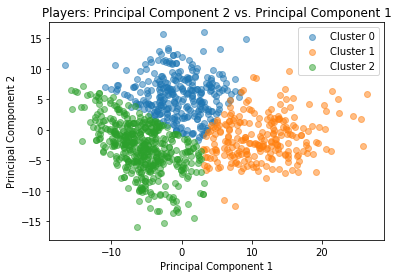

In [675]:
xax = 'Principal Component 1'
yax = 'Principal Component 2'
a = 0.5

for i in range(km.n_clusters):
    plt.scatter(reduced[reduced[:,3] == i][:,0],
              reduced[reduced[:,3] == i][:,1], 
              label = 'Cluster {}'.format(i), alpha = a)


plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Players: ' + yax + ' vs. ' + xax)

plt.show()

In [673]:
reduced.shape

(994, 4)

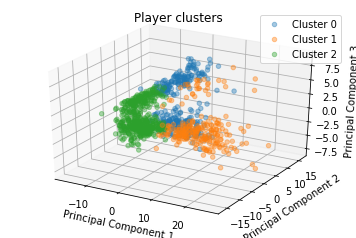

In [674]:
xax = 'Principal Component 1'
yax = 'Principal Component 2'
zax = 'Principal Component 3'
a=0.4

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for i in range(km.n_clusters):
    ax.scatter(reduced[reduced[:,3] == i][:,0], 
               reduced[reduced[:,3] == i][:,1], 
                zs = reduced[reduced[:,3] == i][:,2], 
              label = 'Cluster {}'.format(i), alpha = a)

ax.set_xlabel(xax)
ax.set_ylabel(yax)
ax.set_zlabel(zax)
ax.set_title('Player clusters')

plt.legend()
plt.show()

In [710]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))
split = X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test

X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

pca = PCA(n_components = 3).fit(X_train_s)
reduced = np.dot(X_train_s, pca.components_.T)
red_test = np.dot(X_test_s, pca.components_.T)

km = KMeans(n_clusters = 5)
clus = km.fit_transform(reduced)
X_train_s = np.hstack((X_train_s, km.labels_.reshape(-1,1)))
reduced = np.hstack((reduced, km.labels_.reshape(-1,1)))
#forwards['cluster'] = fkm.labels_
X_train = np.hstack((X_train, km.labels_.reshape(-1,1)))
X_test_s = np.hstack((X_test_s, km.predict(red_test).reshape(-1,1)))
X_test = np.hstack((X_test, km.predict(red_test).reshape(-1,1)))

clusts = []
cmeans = []
for i in range(km.n_clusters):
    clusts.append(X_train_s[km.labels_ == i])
    cmeans.append(clusts[i].mean(axis=0))

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

split = X_train_s, X_test_s, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test

for i in range(km.n_clusters):
    print('cluster '+str(i) + '  -----------------')
    div_list = [X_train_s[X_train_s[:,-1] == i], 0, 
                yp_train[X_train_s[:,-1] == i], 0,
               yl_train[X_train_s[:,-1] == i], 0,
               scap_train[X_train_s[:,-1] == i], 0]
    for idx, div in enumerate(split):
        if idx % 2 != 0:
            div_list[idx] = div[X_test_s[:,-1] == i]
    for r in reg_list:
        run_regressor(div_list, r)
        print()

RMSE pick mean cap_pct: 2.52%
    translates to 2019 Cap Hit of: $2091600.0
RMSE pick mean length: 1.8 years

cluster 0  -----------------
LinearRegression
RMSE Cap_pct: 1.2%
    translates to 2019 Cap Hit of: $996000.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 1.43%
    translates to 2019 Cap Hit of: $1186900.0
RMSE Length: 1.6 years

GradientBoostingRegressor
RMSE Cap_pct: 1.57%
    translates to 2019 Cap Hit of: $1303100.0
RMSE Length: 1.7 years

AdaBoostRegressor
RMSE Cap_pct: 1.43%
    translates to 2019 Cap Hit of: $1186900.0
RMSE Length: 1.7 years

KNeighborsRegressor
RMSE Cap_pct: 2.06%
    translates to 2019 Cap Hit of: $1709800.0
RMSE Length: 2.2 years

cluster 1  -----------------
LinearRegression
RMSE Cap_pct: 1.2%
    translates to 2019 Cap Hit of: $996000.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 0.91%
    translates to 2019 Cap Hit of: $755300.0
RMSE Length: 1.2 years

GradientBoostingRegressor
RMSE Cap_pct: 0.67%
    translates to 2

In [714]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(n_estimators = 100)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))


Xl_train, Xl_test = X_train.copy(), X_test.copy()
Xl_train = np.hstack((Xl_train, model.predict(Xl_train).reshape(-1,1), (Xl_train[:,1]**2).reshape(-1,1)))
Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1), (Xl_test[:,1]**2).reshape(-1,1)))

print('LinearRegression')
l_model = LinearRegression()
l_model.fit(Xl_train, yl_train)
length_preds = l_model.predict(Xl_test)
print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))

GradientBoostingRegressor
RMSE Cap_pct: 0.98%
    translates to 2019 Cap Hit of: $813400.0
LinearRegression
RMSE Length: 1.1 years


In [607]:
from sklearn.linear_model import LassoCV, RidgeCV

In [608]:
las = LassoCV()

In [609]:
las.fit(X_train, yp_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [615]:
sum(abs(las.coef_) > 0.001)

4

In [ ]:
las.f

In [616]:
rid = RidgeCV()
rid.fit(X_train, yp_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [619]:
sum(abs(rid.coef_) > 0.1)

14

In [620]:
cap_preds = las.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

RMSE Cap_pct: 1.14%
    translates to 2019 Cap Hit of: $946199.0


In [621]:
cap_preds = rid.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

RMSE Cap_pct: 1.14%
    translates to 2019 Cap Hit of: $946199.0


In [721]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

run_regressor(split, GradientBoostingRegressor)

RMSE pick mean cap_pct: 2.7%
    translates to 2019 Cap Hit of: $2241000.0
RMSE pick mean length: 1.8 years

GradientBoostingRegressor
RMSE Cap_pct: 0.84%
    translates to 2019 Cap Hit of: $697200.0
RMSE Length: 1.1 years


(0.84, 1.1)

In [722]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

In [749]:
class SalaryLengthPredictor():
    def __init__(self, m = GradientBoostingRegressor, year = 2019):
        self.m = m
        
        self.scap = {
            2005: 39000000,
            2006: 44000000,
            2007: 50300000,
            2008: 56700000,
            2009: 56800000,
            2010: 59400000,
            2011: 64300000,
            2012: 60000000,
            2013: 64300000,
            2014: 69000000,
            2015: 71400000,
            2016: 73000000,
            2017: 75000000,
            2018: 79500000,
            2019: 83000000,
           }
        self.year = year
        self.year_cap = self.scap[year]
        pass
    
    def fit(self, X_train, yp_train, yl_train):
        '''
        Fit a model (default sklearn's GradientBoostingRegressor) for salary cap_pct
        and contract length
        '''
        self.X_train = X_train
        self.yp_train = yp_train
        self.yl_train = yl_train
        
        self.sal_model = self.m()
        self.sal_model.fit(X_train, yp_train)
        
        Xl_train = X_train.copy()
        Xl_train = np.hstack((Xl_train, self.sal_model.predict(Xl_train).reshape(-1,1)))

        self.len_model = self.m()
        self.len_model.fit(Xl_train, yl_train)
        pass
    
    def predict(self, X):
        '''
        Predict salary cap_pct and contract length
        '''
        self.cap_preds = self.sal_model.predict(X)
        Xl_test = X.copy()
        Xl_test = np.hstack((Xl_test, self.cap_preds.reshape(-1,1)))
        self.length_preds = self.len_model.predict(Xl_test)        
        
        return self.cap_preds, self.length_preds
    
    def score(self, X_test, yp_test, yl_test):
        '''
        Return RMSE for salary cap_pct, equivalent salary in $ for 2019 (default), 
        and RMSE for contract length
        '''
        cap_preds, len_preds = self.predict(X_test)
        self.p_rmse = self.rmse(cap_preds, yp_test, 2)
        self.cap_hit = self.p_rmse * self.year_cap // 100
        self.l_rmse = self.rmse(len_preds, yl_test, 1)
        print('RMSE Cap_pct: {}%'.format(self.p_rmse))
        print('    translates to {} Cap Hit of: ${}'.format(self.year, self.cap_hit))
        print('RMSE Length: {} years'.format(self.l_rmse))
        return self.p_rmse, self.cap_hit, self.l_rmse
    
    def rmse(self, yhat, y, round_to = None):
        ''' Return root mean squared error of a set of predictions '''
        err = np.sqrt(((yhat - y)**2).mean())
        if round_to:
            return round(err, round_to)
        else:
            return err

In [750]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

model = SalaryLengthPredictor()

RMSE pick mean cap_pct: 2.45%
    translates to 2019 Cap Hit of: $2033500.0
RMSE pick mean length: 1.7 years



In [751]:
model.fit(X_train, yp_train, yl_train)

In [752]:
preds = model.predict(X_test)

In [753]:
model.cap_preds.shape, yp_test.shape

((176,), (176,))

In [754]:
model.score(X_test, yp_test, yl_test)

RMSE Cap_pct: 0.99%
    translates to 2019 Cap Hit of: $821700.0
RMSE Length: 1.1 years


(0.99, 821700.0, 1.1)

In [ ]:
GridSearchCV(GradientBoostingRegressor, 
            )